# Case Studies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [2]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data


def cumulative_sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters

In [108]:
def CaseStudyPlots(simulation_names,ids, names):
    print(len(ids))
    c_sfhs, bcs = [], []
    for simulation_name, i in zip(simulation_names, ids):
        print(f'Gathering data... for {simulation_name}-{i}')
        c_sfh, bc = cumulative_sfh(simulation_name, i)
        c_sfhs.append(c_sfh)
        bcs.append(bc)
    
    %matplotlib inline
    fig, ax = plt.subplots(2,len(ids),figsize=(2.6*len(ids),5),dpi=300, sharex=True)
    print(list(range(len(ids))))
    for column, (simulation_name, i, c_sfh, bc , name) in enumerate(zip(simulation_names, ids, c_sfhs, bcs, names)):
        haloid = i
        data = read_file(simulation_name, i)
        # data[:10]

        age = 13.800797497330507

        time = age - np.array(data['time'], dtype=float)
        gasfrac = np.array(data['gasfrac'], dtype=float)
        gastemp = np.array(data['gtemp'], dtype=float)
        ratio = np.array(data['ratio'], dtype=float)
        dist = np.array(data['h1dist'], dtype=float)
        SNHf = np.array(data['SNHfrac'], dtype=float)
        fHI = np.array(data['fHI'], dtype=float)
        mvir = np.array(data['mass'], dtype=float)
        HIratio = np.array(data['HIratio'], dtype=float)
        mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
        mgas = np.array(data['mgas'],dtype=float)

        tquench = np.max(bc[c_sfh >= 0.99])
        try:
            tgas = np.max(time[gasfrac < 0.1])
        except:
            tgas = None

        for t, Hi in zip(time, HIratio):
            if Hi > 0.2:
                tHI = t
                break
            else:
                tHI = None

        for x in [0,1]:
            ax[x,column].fill_between(time, -1, 2, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')
            ax[x,column].plot([tquench, tquench],[-2,2], 'r--', linewidth=1)
            ax[x,column].plot([tHI, tHI], [-2,2], 'b--', linewidth=1)
            if not tgas==None:
                ax[x,column].plot([tgas, tgas],[-2,2], 'k--', linewidth=1)

        ax[0,column].plot(bc, c_sfh, 'r-')
        ax0 = ax[0,column].twinx()
        ax0.plot(time, HIratio, 'b-')
        if column==0:
            label1 = ax[0,column].set_ylabel('Cumulative SFH')
            label1.set_color('r')
        else:
            ax[0,column].set_yticklabels([])

        ax[0,column].set_xlim(13,0)
        ax[0,column].set_ylim(-0.05, 1.05)
        ax0.set_ylim(0,9)
        if column==len(ids)-1:
            label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
            label2.set_color('b')
        else:
            ax0.set_yticklabels([])

        ax[1,column].plot(time, gasfrac, 'k-')
        ax1 = ax[1,column].twinx()
        ax1.plot(time[np.around(data.time,decimals=2)!=3.73], dist[np.around(data.time,decimals=2)!=3.73], 'g-')
        ax1.set_ylim(0.1,25)
        ax1.semilogy()
        ax[1,column].set_ylim(-0.05, 1.05)
        ax[1,column].set_xlabel('Lookback Time [Gyr]')
        ax[1,column].set_xlim(13,0)
        if column==len(ids)-1:
            label3 = ax1.set_ylabel('Distance to Host [kpc]')
            label3.set_color('g')
            ax1.set_yticklabels([None,0.1,1,10])
        else:
            ax1.set_yticklabels([])
            
        if column==0:
            label4 = ax[1,column].set_ylabel('Gas Fraction')
            label4.set_color('k')
        else:
            ax[1,column].set_yticklabels([])

        for axis in [ax[0,column],ax[1,column],ax0,ax1]:
            axis.tick_params(direction='in',which='both')

        ax[0,column].xaxis.set_ticks_position('both')
        ax[1,column].xaxis.set_ticks_position('both')
        ax[1, column].set_xticks([12, 10, 8, 6, 4, 2, 0])
        ax[1, column].set_xticklabels(['12', '10', '8', '6', '4', '2', '0'])
        ax[1, column].annotate(f'{name}-{i}',(12,0.04), size=12)
        
    plt.subplots_adjust(hspace=0., wspace=0.)  
    plt.savefig('casestudies.png',dpi=300)
    plt.show()

2
Gathering data... for h242-41
Gathering data... for h229-55
[0, 1]


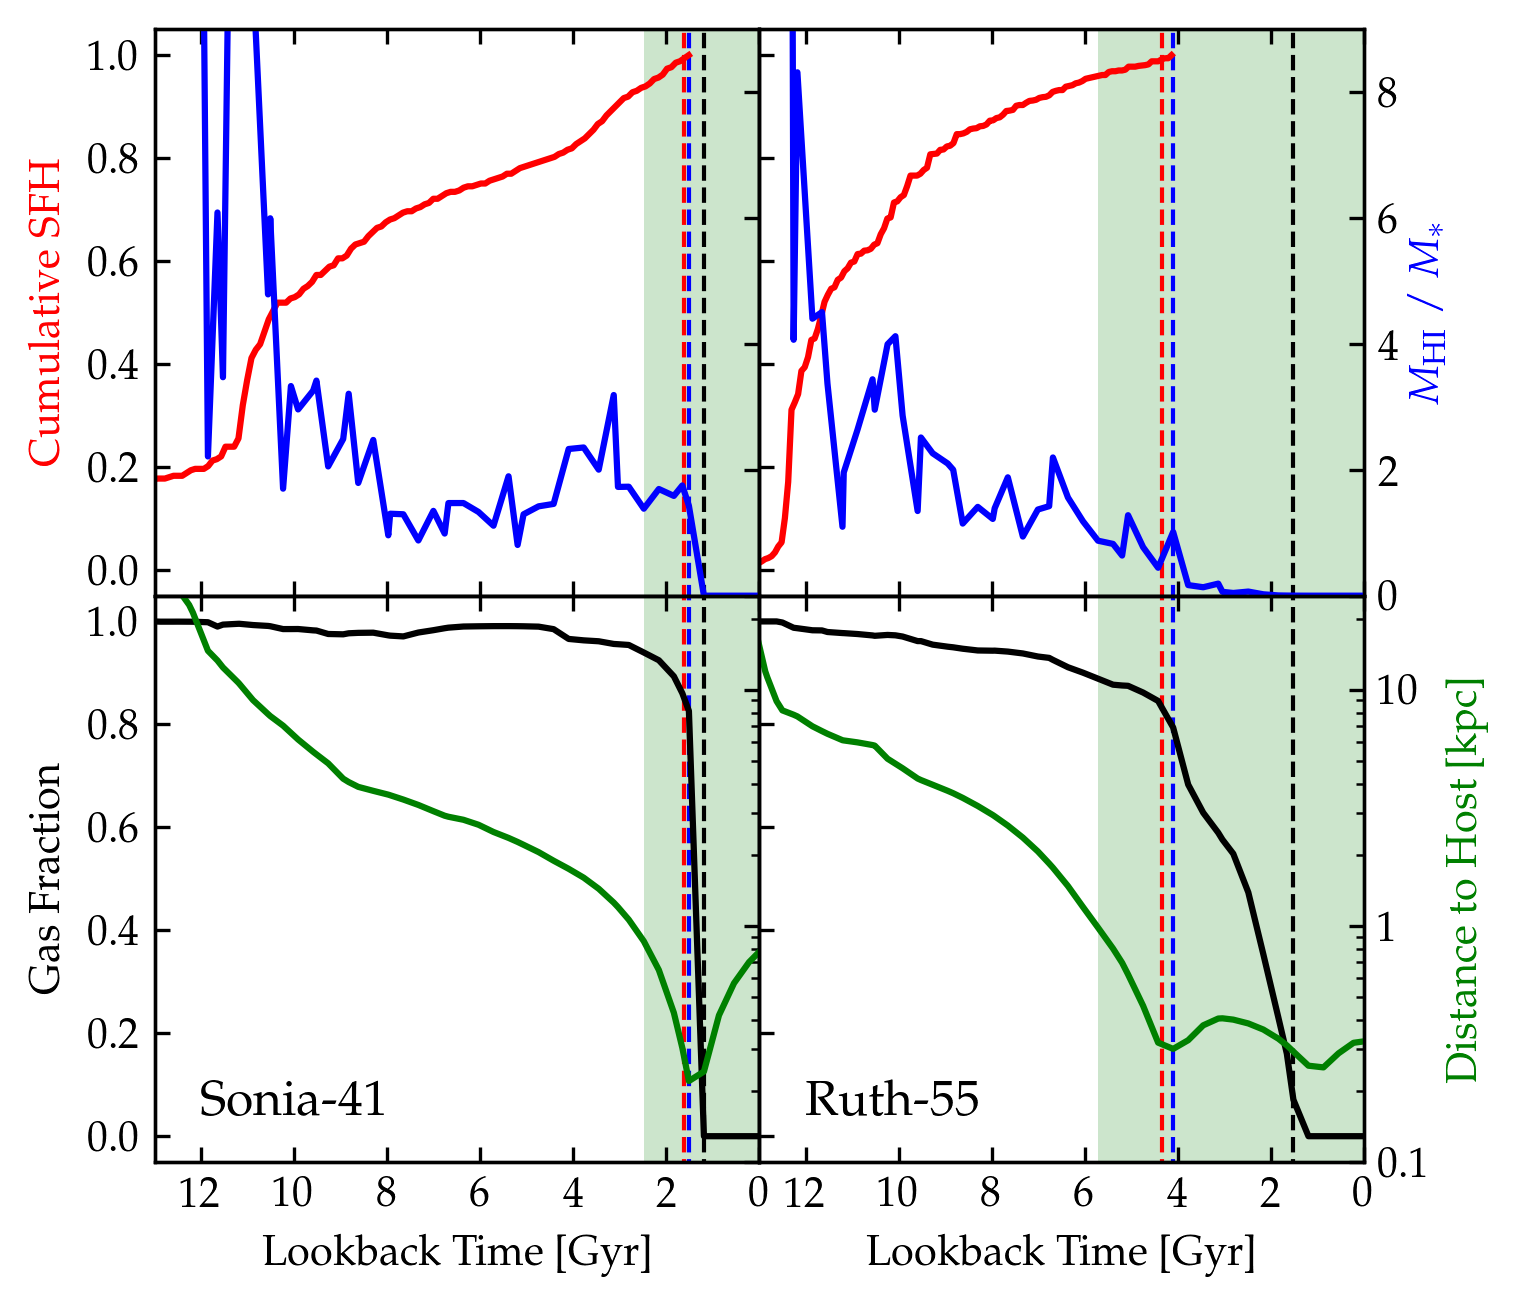

In [109]:
CaseStudyPlots(['h242','h229'],[41,55], ['Sonia','Ruth'])

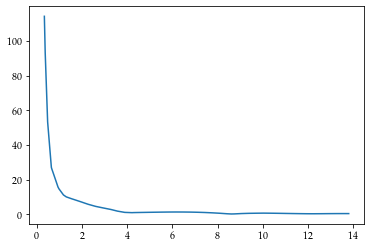

In [22]:
data = read_file('h229',22)
plt.plot(data.time[np.around(data.time,decimals=2)!=3.73], data.h1dist[np.around(data.time,decimals=2)!=3.73])
plt.show()

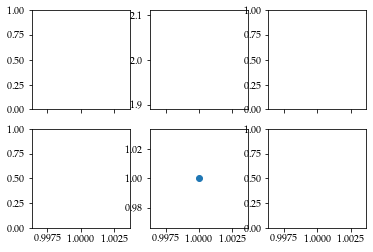

In [46]:
fig, ax = plt.subplots(2,3, sharex=True)

a = ax[:,1]

a[0].plot([1,1],[2,2])
a[1].scatter([1],[1])

plt.show()